# Using logic to solve the wolf, corn and goose problem

Given a wolf, corn, goose and farmer and three locations west, boat and east where the wolf cant be left with the corn and the corn cant be left with the goose. How can the farmer move every entity to from the west to the east if the boat can only hold the farmer and one other entity at a time.

First we must come up with a notation to describe the entity and its position.

In [1]:
WW, WB, WE = 'WW', 'WB', 'WE'
CW, CB, CE = 'CW', 'CB', 'CE'
GW, GB, GE = 'GW', 'GB', 'GE'
FW, FB, FE = 'FW', 'FB', 'FE'
states = [WW, WB, WE, CW, CB, CE, GW, GB, GE, FW, FB, FE]
print(states)

['WW', 'WB', 'WE', 'CW', 'CB', 'CE', 'GW', 'GB', 'GE', 'FW', 'FB', 'FE']


Here we use the first letter of the location and entity to represent the state, for example WW means the wolf is on the west.

The number of subsets is $2^n$, where n is the size of the set, so for this problem their is $2^{12} = 4096$ subsets, which can be demonstrated bellow by finding all subsets.

In [2]:
from itertools import combinations

subsets=[]
for i in range(len(states)+1):
    subsets.extend(combinations(states, r=i))
        
print(len(subsets))

4096


Not all of these subsets are valid, for example each entity can only be at one place at a time. To represent that with logic we can use the following:
$$(WW \oplus WB \oplus WE) \land \overline{WW \land WB \land WE}$$

> Interestingly xoring a number of things will return true if an odd amount of them are true, this in this case we must ensure the case were the wolf is in all 3 locations is false, hence the and.

In [3]:
wolf = lambda s: ((WW in s) ^ (WB in s) ^ (WE in s)) and not((WW in s) and (WB in s) and (WE in s))
corn = lambda s: ((CW in s) ^ (CB in s) ^ (CE in s)) and not((CW in s) and (CB in s) and (CE in s))
goose = lambda s: ((GW in s) ^ (GB in s) ^ (GE in s)) and not((GW in s) and (GB in s) and (GE in s))
farmer = lambda s: ((FW in s) ^ (FB in s) ^ (FE in s)) and not((FW in s) and (FB in s) and (FE in s))

for f in [wolf, corn, goose, farmer]:
    subsets=list(filter(f, subsets))

print(len(subsets))

81


No we have reduced the number of states to 81. We know that this is correct since their are 4 entities which can be in 3 locations thus their are $3^4 = 81$ states.

Again not all these states are legal, since the farmer must travel with another entity, the following must be true
$$
WB \rightarrow FB \\
CB \rightarrow FB \\
GB \rightarrow FB
$$

In [4]:
def impl(lhs, rhs):
    return rhs if lhs else True

wolf = lambda s: impl(WB in s, FB in s)
corn = lambda s: impl(CB in s, FB in s)
goose = lambda s: impl(GB in s, FB in s)

for f in [wolf, corn, goose]:
    subsets=list(filter(f, subsets))

print(len(list(subsets)))

43


The farmer can only take one other entity at a time, thus:
$$\overline{WB \land CB} \land \overline{CB \land GB} \land \overline{GB \land WB}$$

In [5]:
valid_boat = lambda s: not((WB in s) and (CB in s)) and \
                       not((CB in s) and (GB in s)) and \
                       not((GB in s) and (WB in s))
        
subsets=list(filter(valid_boat, subsets))
print(len(list(subsets)))

36


All that is left now is to remove all the unsafe states

__The Wolf cant be left with corn__, thus if the wolf and corn are in the same location the farmer must also be at that locations:
$$
WW \land GW \rightarrow FW \\
WE \land GE \rightarrow FE
$$

Similarly, __the corn cant be left with goose__, thus if the goose and corn are in the same location the farmer is also their:
$$
CW \land GW \rightarrow FW \\ 
CE \land GE \rightarrow FE
$$

In [6]:
wolf_corn_west = lambda s: FW in s if ((WW in s) and (GW in s)) else True
wolf_corn_east = lambda s: FE in s if ((WE in s) and (GE in s)) else True
corn_goose_west = lambda s: FW in s if ((CW in s) and (GW in s)) else True
corn_goose_east = lambda s: FE in s if ((CE in s) and (GE in s)) else True

subsets=list(filter(wolf_corn_west, subsets))
subsets=list(filter(wolf_corn_east, subsets))
subsets=list(filter(corn_goose_west, subsets))
subsets=list(filter(corn_goose_east, subsets))

print(len(subsets))

20


Finally we are left with just 20 states that are legal and safe. The 20 states are as follows:

In [7]:
for s in subsets:
    print(', '.join(s))

WW, CW, GW, FW
WW, CW, GB, FB
WW, CW, GE, FW
WW, CW, GE, FB
WW, CW, GE, FE
WW, CB, GE, FB
WW, CE, GW, FW
WW, CE, GB, FB
WW, CE, GE, FE
WB, CW, GE, FB
WB, CE, GW, FB
WE, CW, GW, FW
WE, CW, GB, FB
WE, CW, GE, FE
WE, CB, GW, FB
WE, CE, GW, FW
WE, CE, GW, FB
WE, CE, GW, FE
WE, CE, GB, FB
WE, CE, GE, FE


Even though we have found all the safe states, we still cant answer questions such as what is the minimum number of steps required to cross the river. To do that we will need to transform the states into a graph where the edges would represent valid transitions from one state to another.

In order to form this graph we must start by defining what a valid transition is. For example if an entity was on the west, in the next state it cant be in the east and visa versa.
$$
WW' \rightarrow \overline{WE'} \\
CW' \rightarrow \overline{CE'} \\
GW' \rightarrow \overline{GE'} \\
FW' \rightarrow \overline{FE'}
$$
(repeated for the oppisite direction)

If the farmer is in the boat with another entity, the farmer must have been in the boat or they were both on the same side.
$$
FB \lor WB \rightarrow FB \lor (WE \land FE) \lor (WW \land FW) \\
CB \lor CB \rightarrow FB \lor (CE \land FE) \lor (CW \land FW) \\
GB \lor GB \rightarrow FB \lor (GE \land FE) \lor (GW \land FW)
$$

If the farmer and another entity are on opposite sides, they both cant end up in the boat.
$$
(FE \land WW) \lor (FW \land WE) \rightarrow \overline{WB'} \\
(FE \land CW) \lor (FW \land CE) \rightarrow \overline{CB'} \\
(FE \land GW) \lor (FW \land GE) \rightarrow \overline{GB'}
$$

Entities (except from the farmer) cannot stay in the boat. 
$$
\overline{WB' \lor CB' \lor GB'} \rightarrow WB \lor CB \lor GB
$$

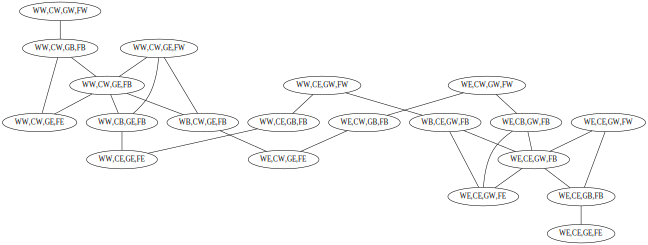

In [8]:
import graphviz

d = graphviz.Graph(engine='dot')

n = len(subsets)
for i in range(n):
    for j in range(i+1, n):
        s1, s2 = subsets[i], subsets[j]

        wolf_1 =   impl(WW in s1, WE not in s2) and impl(WE in s1, WW not in s2)
        corn_1 =   impl(CW in s1, CE not in s2) and impl(CE in s1, CW not in s2)
        goose_1 =  impl(GW in s1, GE not in s2) and impl(GE in s1, GW not in s2)
        farmer_1 = impl(FW in s1, FE not in s2) and impl(FE in s1, FW not in s2)
        
        wolf_2 =  impl(FB in s1 and WB in s1, FB in s2 or (WE in s2 and FE in s2) or (WW in s2 and FW in s2))
        corn_2 =  impl(FB in s1 and CB in s1, FB in s2 or (CE in s2 and FE in s2) or (CW in s2 and FW in s2))
        goose_2 = impl(FB in s1 and GB in s1, FB in s2 or (GE in s2 and FE in s2) or (GW in s2 and FW in s2))
        
        wolf_3 =  impl((FE in s1 and WW in s1) or (FW in s1 and WE in s1), WB not in s2)
        corn_3 =  impl((FE in s1 and CW in s1) or (FW in s1 and CE in s1), CB not in s2)
        goose_3 = impl((FE in s1 and GW in s1) or (FW in s1 and GE in s1), GB not in s2)
        
        boat = impl((WB in s1 or CB in s1 or GB in s1), not(WB in s2 or CB in s2 or GB in s2)) 
        
        if wolf_1 and corn_1 and goose_1 and farmer_1 and \
            wolf_2 and corn_2 and goose_2 and \
            wolf_3 and corn_3 and goose_3 and boat:
            d.edge(','.join(s1), ','.join(s2))

d.graph_attr['size'] = '9,15'
d